<a href="https://colab.research.google.com/github/jhlee508/gan-augmentations/blob/master/classification_with_pytorch_85acc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classification using the CNN pyTorch

**Mounting Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Seed Setting**

In [ ]:
import torch
import numpy as np
import random
import os

def my_seed_everywhere(seed: int = 42):
    random.seed(seed) # random
    np.random.seed(seed) # numpy
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    # pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed) 
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False 

my_seed = 42
my_seed_everywhere(my_seed)

Importing libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import os
from torchvision import transforms
from sklearn.metrics import roc_curve, auc
from glob import glob

Make the transformer that includes RandomRotation, ToTensor and Normalize steps. 

In [ ]:
data_transforms = transforms.Compose([
            #transforms.RandomRotation(90, resample=PIL.Image.BILINEAR),
            #transforms.RandomApply((transforms.RandomHorizontalFlip(.5), 
            #                        transforms.RandomVerticalFlip(.5)), p=0.5),
            transforms.ToTensor(), 
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

Using pyTorch datasets read the train/test samples and split train set to train and validation sets. 

In [ ]:
from glob import glob

train_mal = glob('/content/drive/Shareddrives/SKKU-URP-GAN/all/jh/real_200/train/malignant/mal/*.jpg')
train_ben = glob('/content/drive/Shareddrives/SKKU-URP-GAN/all/jh/real_200/train/benign/ben/*.jpg')

print(len(train_mal))
print(len(train_ben))

200
1440


In [ ]:
trainset = dset.ImageFolder('/content/drive/Shareddrives/SKKU-URP-GAN/all/jh/real_200/train', 
                            transform=data_transforms)
testset = dset.ImageFolder('/content/drive/Shareddrives/SKKU-URP-GAN/all/test', 
                           transform=data_transforms)


data_size = len(trainset.samples)
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)
batch_size = 8
train_indices, val_indices = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)


train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         sampler=val_sampler)


test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

Make Flattener object

In [ ]:
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Function for training model, computing accuracy and plotting train/val curves.

In [ ]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    print('using device: cuda')
else:
    print('using device: cpu')

using device: cuda


In [ ]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    

    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0

        for i_step, (x, y) in enumerate(train_loader):
            
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print(f"Average loss: {ave_loss}, \
            Train accuracy: {train_accuracy}, \
            Val accuracy: {val_accuracy}")
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader, auc=False):
    model.eval() 
    correct_samples = 0
    total_samples = 0
    y_true, y_pred = [], []
    for (x, y) in loader:
      
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        prediction = model(x_gpu)    
        indices = torch.argmax(prediction, 1)
        fpr, tpr, _ = roc_curve(y_gpu.cpu().detach().numpy(), indices.cpu().detach().numpy())

        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y_gpu.shape[0]
        accuracy = float(correct_samples) / total_samples
        torch.cuda.get_device_name(0)
        if auc:
            y_true.extend(y_gpu.cpu().detach().numpy())
            y_pred.extend(indices.cpu().detach().numpy())
    if auc:
        return accuracy, y_true, y_pred
    else: 
        return accuracy
    
    

    return accuracy, y_true, y_pred

def loss_accuracy_plot(loss_history, train_history, val_history):
    plt.figure(figsize=(10, 9))
    plt.subplot(311)
    # plt.ylim(bottom=0)
    plt.title("Loss")
    plt.plot(loss_history)
    plt.subplot(312)
    plt.ylim((.5, 1))
    plt.title("Train/validation accuracy")
    plt.plot(train_history, label="train")
    plt.plot(val_history, label="validation")

    plt.legend();

Creating the model, defining loss and optimizer for training procedure. 

In [ ]:
device = torch.device('cuda')
# torch.set_num_threads(16)
print(torch.cuda.get_device_name(0))

nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(24),    
            Flattener(),
            nn.Linear(64*2*2, 2),
          )

device = torch.device("cuda" if torch.cuda.is_available else "cpu")
nn_model.type(torch.cuda.FloatTensor)

nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)

# optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer = optim.Adam(nn_model.parameters(), lr=0.001, 
                       betas=(0.9, 0.999), eps=1e-08, 
                       weight_decay=0.0001, amsgrad=False)

Tesla P100-PCIE-16GB


In [ ]:
my_seed = 42
my_seed_everywhere(my_seed)

Curves, accuracy

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


Average loss: 0.33336031436920166,             Train accuracy: 0.8711890243902439,             Val accuracy: 0.8871951219512195
Average loss: 0.25844359397888184,             Train accuracy: 0.8894817073170732,             Val accuracy: 0.9054878048780488
Average loss: 0.23822195827960968,             Train accuracy: 0.899390243902439,             Val accuracy: 0.9115853658536586
Average loss: 0.20983363687992096,             Train accuracy: 0.9085365853658537,             Val accuracy: 0.9085365853658537
Average loss: 0.1959579437971115,             Train accuracy: 0.9108231707317073,             Val accuracy: 0.8963414634146342
Average loss: 0.16412973403930664,             Train accuracy: 0.9352134146341463,             Val accuracy: 0.9024390243902439
Average loss: 0.15496058762073517,             Train accuracy: 0.9352134146341463,             Val accuracy: 0.899390243902439
Average loss: 0.14820699393749237,             Train accuracy: 0.9367378048780488,             Val accuracy

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


Final accuracy on the test set is: 0.6287878787878788; auc is: 0.5930555555555556


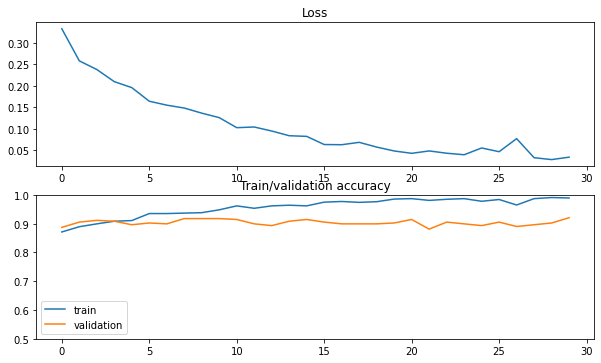

In [ ]:
loss_history, train_history, val_history = train_model(nn_model, 
                                                       train_loader, 
                                                       val_loader, 
                                                       loss, 
                                                       optimizer, 30)

loss_accuracy_plot(loss_history, train_history, val_history)

print('Finished!')

test_accuracy, y_true, y_pred = compute_accuracy(nn_model, test_loader, auc=True)

fpr, tpr, _ = roc_curve(y_true, y_pred)
auc_rate = auc(fpr, tpr)


print(f'Final accuracy on the test set is: {test_accuracy}; auc is: {auc_rate}')

mal_200_first_epoch - Average loss: 0.2665477693080902,             Train accuracy: 0.8956851588430536,             Val accuracy: 0.9392789373814042

mal_200_last_epoch - Average loss: **0.04**7655943781137466, Train accuracy: **0.98**48269321953532, Val accuracy: **0.95**06641366223909

---
---

mal_100_first_epoch - Average loss: 0.16774296760559082,             Train accuracy: 0.9350710900473934,             Val accuracy: 0.9544592030360531

mal_100_last_epoch - Average loss: 0.010414835065603256,             Train accuracy: 0.9957345971563981,             Val accuracy: 0.9582542694497154

---
---

mal_50_first_epoch - Average loss: 0.2665477693080902,             Train accuracy: 0.8956851588430536,             Val accuracy: 0.9392789373814042

mal_50_last_epoch - Average loss: 0.047655943781137466,             Train accuracy: 0.9848269321953532,             Val accuracy: 0.9506641366223909

---
---

real_200_first_epoch - Average loss: 0.33336031436920166,             Train accuracy: 0.8711890243902439,             Val accuracy: 0.8871951219512195

real_200_last_epoch - Average loss: 0.03350691497325897,             Train accuracy: 0.989329268292683,             Val accuracy: 0.9207317073170732

In [ ]:
test_accuracy, y_true, y_pred = compute_accuracy(nn_model, test_loader, auc=True)

fpr, tpr, _ = roc_curve(y_true, y_pred)
auc_rate = auc(fpr, tpr)


print(f'Final accuracy on the test set is: {test_accuracy}; auc is: {auc_rate}')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


Final accuracy on the test set is: 0.6287878787878788; auc is: 0.5930555555555556


mal_200 - Final accuracy on the test set is: 0.6757575757575758, auc is: 0.6483333333333333

mal_100 - Final accuracy on the test set is: 0.5772727272727273, auc is: 0.535

mal_100 - Final accuracy on the test set is: 0.6757575757575758; auc is: 0.6483333333333333

All - 
Final accuracy on the test set is: 0.8272727272727273; auc is: 0.8322222222222223

All - Final accuracy on the test set is: 0.8393939393939394; auc is: 0.8366666666666667

Real_200 - Final accuracy on the test set is: 0.6287878787878788; auc is: 0.5930555555555556